In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving “EV Vehicle dataset.csv to “EV Vehicle dataset.csv
User uploaded file "“EV Vehicle dataset.csv" with length 1216895 bytes


In [2]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [3]:
df = pd.read_csv(r"“EV Vehicle dataset.csv")



In [4]:
df.head(10)


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19
5,May 31 2018,Maui,HI,Passenger,1,0,1,59,60,1.67
6,November 30 2017,Northampton,PA,Passenger,0,1,1,66,67,1.49
7,March 31 2018,Nassau,NY,Passenger,1,0,1,37,38,2.63
8,March 31 2020,DeKalb,IN,Passenger,1,0,1,1,2,50.00
9,January 31 2019,Columbia,WA,Truck,0,0,0,"1,529","1,529",0.00


In [5]:
df.shape


(20819, 10)

In [6]:
df. info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [7]:
df.isnull().sum()

,0
Date,0
County,86
State,86
Vehicle Primary Use,0
Battery Electric Vehicles (BEVs),0
Plug-In Hybrid Electric Vehicles (PHEVs),0
Electric Vehicle (EV) Total,0
Non-Electric Vehicle Total,0
Total Vehicles,0
Percent Electric Vehicles,0


In [8]:
# Compute Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


<Axes: ylabel='Percent Electric Vehicles'>

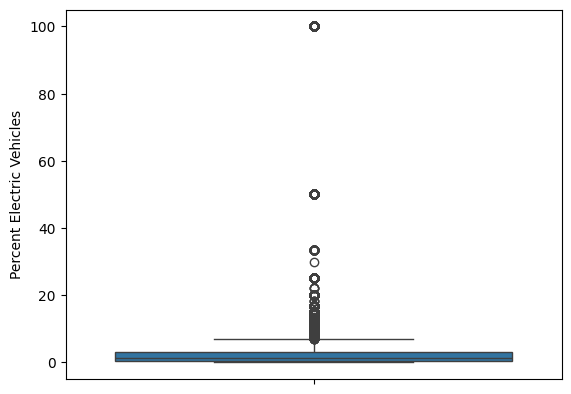

In [9]:
import seaborn as sns
sns.boxplot(df['Percent Electric Vehicles'])


In [10]:
# Convert Date column
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Group by Date and aggregate EV count
monthly_ev = df.groupby('Date')['Electric Vehicle (EV) Total'].sum().reset_index()


In [11]:
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

Missing after fill:
County    0
State     0
dtype: int64


In [12]:
df.head(10)

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
8970,2017-01-31,Contra Costa,CA,Passenger,1,0,1,676,677,0.15
3493,2017-01-31,Island,WA,Truck,1,0,1,"20,515","20,516",0.00
20411,2017-01-31,Volusia,FL,Passenger,0,1,1,52,53,1.89
7518,2017-01-31,Mason,WA,Truck,0,0,0,"19,182","19,182",0.00
10779,2017-01-31,Pierce,WA,Passenger,822,751,"1,573","528,213","529,786",0.30
4356,2017-01-31,Unknown,Unknown,Passenger,2,0,2,484,486,0.41
2275,2017-01-31,Hawaii,HI,Passenger,1,0,1,92,93,1.08
16608,2017-01-31,Durham,NC,Passenger,0,1,1,39,40,2.50
19651,2017-01-31,El Paso,CO,Passenger,1,1,2,886,888,0.23
5236,2017-01-31,Ferry,WA,Truck,0,0,0,"3,581","3,581",0.00


In [13]:
# Cap the outliers - it keeps all the data while reducing the skew from extreme values.

df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


In [14]:
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[cols_to_convert].describe()


,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20266.000000,20468.000000,20119.000000,13983.000000,13979.000000,20819.000000
mean,25.855176,21.790942,31.623093,132.845312,134.463767,2.122378
std,102.004224,92.309729,115.742017,174.033916,174.448753,2.277542
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,26.000000,27.000000,0.390000
50%,1.000000,1.000000,1.000000,69.000000,70.000000,1.220000
75%,2.000000,1.000000,3.000000,167.000000,169.000000,2.995000
max,999.000000,999.000000,999.000000,999.000000,998.000000,6.902500


In [15]:
county_ev_total = df.groupby('County')['Electric Vehicle (EV) Total'].sum().reset_index()
top_counties_ev = county_ev_total.sort_values(by='Electric Vehicle (EV) Total', ascending=False)
bottom_counties_ev = county_ev_total.sort_values(by='Electric Vehicle (EV) Total', ascending=True)

print("Counties with the most Electric Vehicles:")
display(top_counties_ev.head(5))
print("Counties with the least Electric Vehicles:")
display(bottom_counties_ev.head(5))

Counties with the most Electric Vehicles:


,County,Electric Vehicle (EV) Total
47,Clallam,39839.0
122,Jefferson,39683.0
237,San Juan,39309.0
44,Chelan,34656.0
255,Skagit,32270.0


Counties with the least Electric Vehicles:


,County,Electric Vehicle (EV) Total
29,Brown,1.0
281,Union,1.0
115,Hood River,1.0
22,Bernalillo,2.0
254,Shoshone,2.0


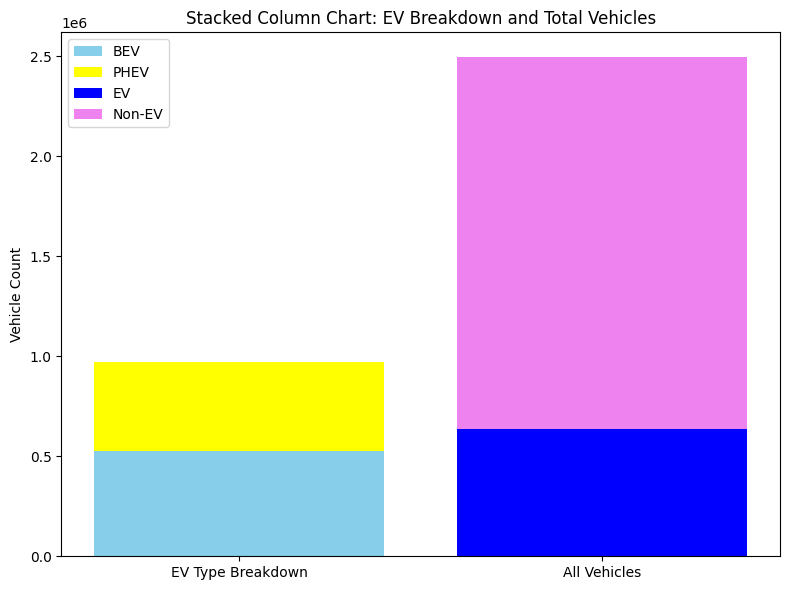

In [16]:
# Total sums for stacked column chart
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()
all_total = df['Total Vehicles'].sum()

# Stacked column chart
fig, ax = plt.subplots(figsize=(8, 6))

# Stack EV types
ax.bar('EV Type Breakdown', bev_total, label='BEV', color='skyblue')
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='yellow')

# Stack Total Vehicle categories
ax.bar('All Vehicles', ev_total, label='EV', color='blue')
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='violet')

# Final touches
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()
plt.tight_layout()
plt.show()

FEATURE ENGINEERING
where we can encode  using pandas and libraries for model making




In [17]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month
le = LabelEncoder()
df['county_encoded'] = le.fit_transform(df['County'])


In [18]:
df = df.sort_values(['County', 'Date'])



In [19]:

# Create lag features
df['ev_total_lag1'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(1)
df['ev_total_lag2'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(2)
df['ev_total_lag3'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(3)

# Create rolling mean feature
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'].rolling(window=3).mean().reset_index(level=0, drop=True)

# Create percentage change features
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'].pct_change(periods=1)
df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'].pct_change(periods=3)

display(df.head())

/tmp/ipython-input-2144099076.py:10: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'].pct_change(periods=1)
/tmp/ipython-input-2144099076.py:11: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'].pct_change(periods=3)


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,year,month,numeric_date,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3
3923,2017-12-31,Ada,ID,Passenger,0.0,1.0,1.0,359.0,360.0,0.28,2017,12,24216,0,NaN,NaN,NaN,NaN,NaN,NaN
19390,2018-01-31,Ada,ID,Passenger,0.0,1.0,1.0,358.0,359.0,0.28,2018,1,24217,0,1.0,NaN,NaN,NaN,0.0,NaN
7549,2018-02-28,Ada,ID,Passenger,0.0,2.0,2.0,354.0,356.0,0.56,2018,2,24218,0,1.0,1.0,NaN,1.333333,1.0,NaN
6698,2018-03-31,Ada,ID,Passenger,0.0,2.0,2.0,346.0,348.0,0.57,2018,3,24219,0,2.0,1.0,1.0,1.666667,0.0,1.0
16059,2018-04-30,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,2018,4,24220,0,2.0,2.0,1.0,2.000000,0.0,1.0


In [21]:
# Assign time index per county
df['months_since_start'] = df.groupby('County').cumcount()

#Lags are only based on past data from the same county
# === Create lag features (1–3 months) ===
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# === Rolling average (3-month, prior) ===
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# === Percent change (no fill method) ===
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# === Clean up any infs/NaNs ===
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)
display(df.head())


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,month,numeric_date,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,months_since_start
3923,2017-12-31,Ada,ID,Passenger,0.0,1.0,1.0,359.0,360.0,0.28,...,12,24216,0,NaN,NaN,NaN,NaN,0.0,0.0,0
19390,2018-01-31,Ada,ID,Passenger,0.0,1.0,1.0,358.0,359.0,0.28,...,1,24217,0,1.0,NaN,NaN,NaN,0.0,0.0,1
7549,2018-02-28,Ada,ID,Passenger,0.0,2.0,2.0,354.0,356.0,0.56,...,2,24218,0,1.0,1.0,NaN,NaN,1.0,0.0,2
6698,2018-03-31,Ada,ID,Passenger,0.0,2.0,2.0,346.0,348.0,0.57,...,3,24219,0,2.0,1.0,1.0,1.333333,0.0,1.0,3
16059,2018-04-30,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,4,24220,0,2.0,2.0,1.0,1.666667,0.0,1.0,4


In [22]:
# Cumulative EV count per county
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

# 6-month rolling linear slope of cumulative growth
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)



In [23]:
df = df.dropna().reset_index(drop=True)
df.to_csv('preprocessed_ev_data.csv', index=False)

df.head()



,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,months_since_start,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,0,2.0,2.0,2.0,2.0,0.0,0.0,5,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,0,2.0,2.0,2.0,2.0,0.0,0.0,6,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,0,2.0,2.0,2.0,2.0,0.0,0.0,7,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,2.0,2.0,2.0,2.0,0.0,0.0,8,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,0,2.0,2.0,2.0,2.0,0.0,0.0,9,18.0,2.000000


In [29]:
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

X.head(5)




,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [31]:
X.shape


(12572, 9)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
y_test.head()



,Electric Vehicle (EV) Total
11314,1.0
11315,1.0
11316,1.0
11317,1.0
11318,1.0


model selection from the best model which give the high accuracy

In [34]:
# Define param distribution
param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None]
}

# Base model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  # 30 random combos
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit model
random_search.fit(X_train, y_train)

# Best model
model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [35]:
# Predict and evaluate
y_pred = model.predict(X_test)
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
11314,97,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11315,98,270,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11316,5,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11317,6,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0
11318,7,271,1.0,1.0,1.0,1.0,0.0,0.0,1.0


after model selection  we should done the model. evaluation by various evaluation methods like

Mean Squared Error (MSE) – Penalizes larger errors.

R² Score – Measures goodness of fit.


In [36]:

comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,
    'Predicted EV Count': y_pred
})

# Round for readability
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

# Optionally reset index if needed
comparison_df.reset_index(drop=True, inplace=True)

comparison_df.head(5)

,Actual EV Count,Predicted EV Count
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0


MAE: 0.01, RMSE: 0.05, R2 Score: 1.00


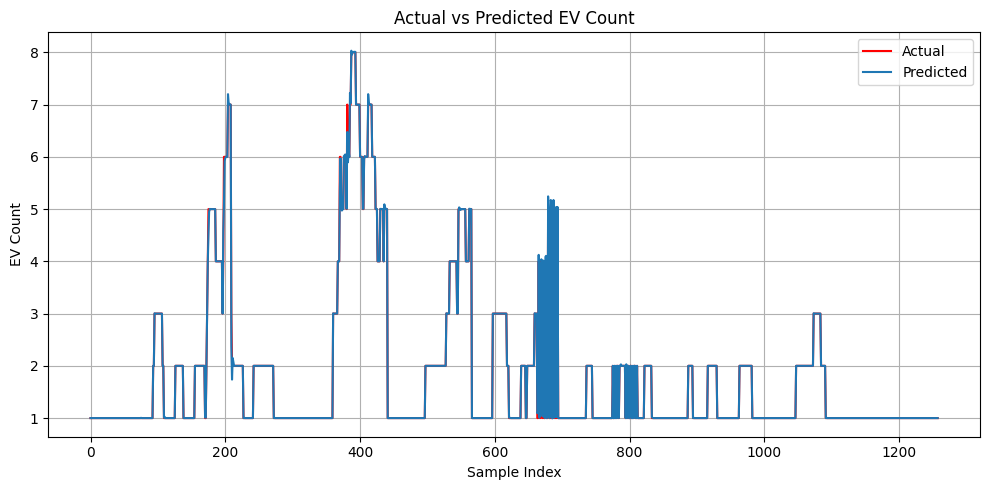

In [42]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2Score:.2f}")

evaluate(y_test, y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual',color='red')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted EV Count")
plt.xlabel("Sample Index")
plt.ylabel("EV Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

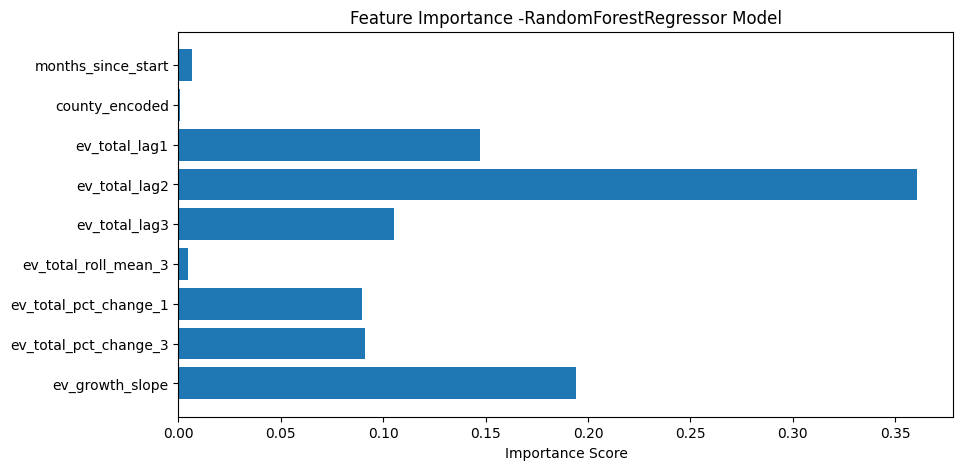

In [47]:
importances = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(10,5))
plt.barh(features, importances)
plt.xlabel('Importance Score')
plt.title('Feature Importance -RandomForestRegressor Model')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

In [52]:
# Define features and target
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

print("Features selected for the model:")
display(X.head(5))

print("\nTarget variable:")
display(y.head(5))
print("Total unique counties:", df['County'].nunique())

Features selected for the model:


,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000



Target variable:


,Electric Vehicle (EV) Total
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0


Total unique counties: 269


County 'Kings' encoded as 130.


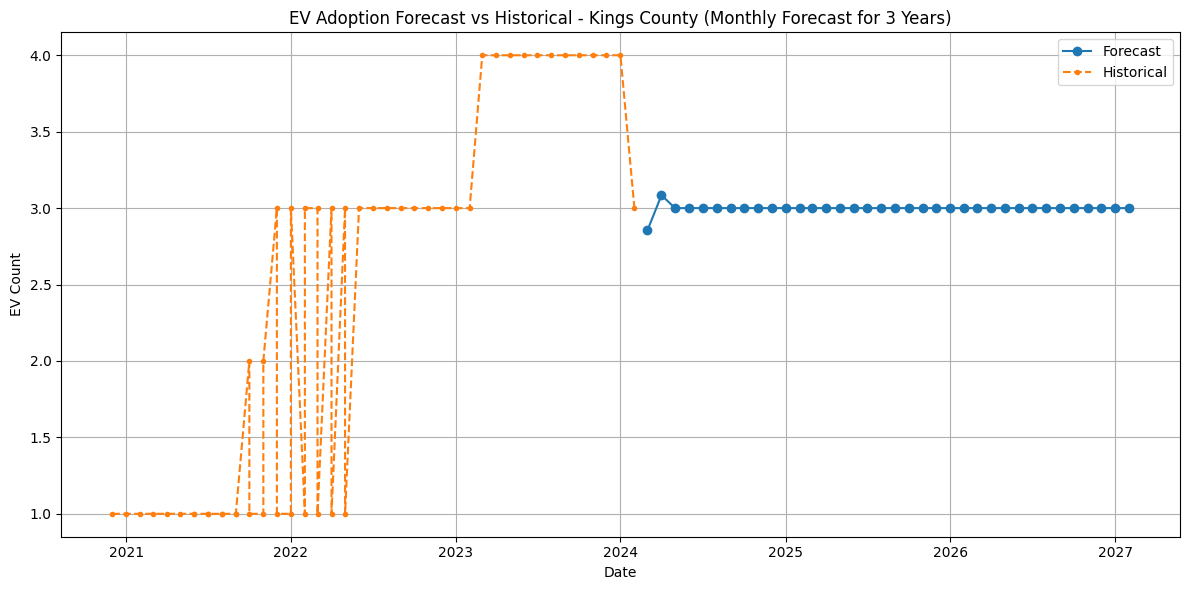

In [53]:
county = "Kings"

# Encode county
try:
    county_code = le.transform([county])[0]
    print(f"County '{county}' encoded as {county_code}.")
except ValueError:
    print(f"Error: '{county}' not found in LabelEncoder.")
    exit()

# Filter historical data
county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
if county_df.empty:
    print(f"Warning: No data found for county '{county}'.")
    exit()

# Prepare EV history
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
slope_history = []
months_since_start = county_df['months_since_start'].max()

historical = county_df[['year', 'month', 'numeric_date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
historical['Source'] = 'Historical'
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))

# Forecast next 36 months
latest_row = county_df.iloc[-1].copy()
future_rows = []

for i in range(1, 37):
    next_date = pd.to_datetime(latest_row['year'] * 100 + latest_row['month'], format='%Y%m') + pd.DateOffset(months=1)
    y, m = next_date.year, next_date.month
    numeric_date = y * 12 + m
    months_since_start += 1

    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

    # Compute slope
    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    # Construct new row (removed year/month/numeric_date/acceleration)
    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    # Predict
    X_new = pd.DataFrame([new_row])[features]
    pred = model.predict(X_new)[0]
    new_row['Electric Vehicle (EV) Total'] = pred

    # Update rolling histories
    historical_ev.append(pred)
    if len(historical_ev) > 6:
        historical_ev.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + pred)
    if len(cumulative_ev) > 6:
        cumulative_ev.pop(0)

    future_rows.append({
        'Date': next_date,
        'Electric Vehicle (EV) Total': pred,
        'months_since_start': months_since_start,
        'Source': 'Forecast'
    })

    latest_row['year'], latest_row['month'] = y, m

# Forecast DataFrame
forecast_df = pd.DataFrame(future_rows)

# Combine and plot
historical['Date'] = pd.to_datetime(historical[['year', 'month']].assign(day=1))
historical = historical[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']]
combined = pd.concat([historical, forecast_df], ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Electric Vehicle (EV) Total'], label=source,
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"EV Adoption Forecast vs Historical - {county} County (Monthly Forecast for 3 Years)")
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


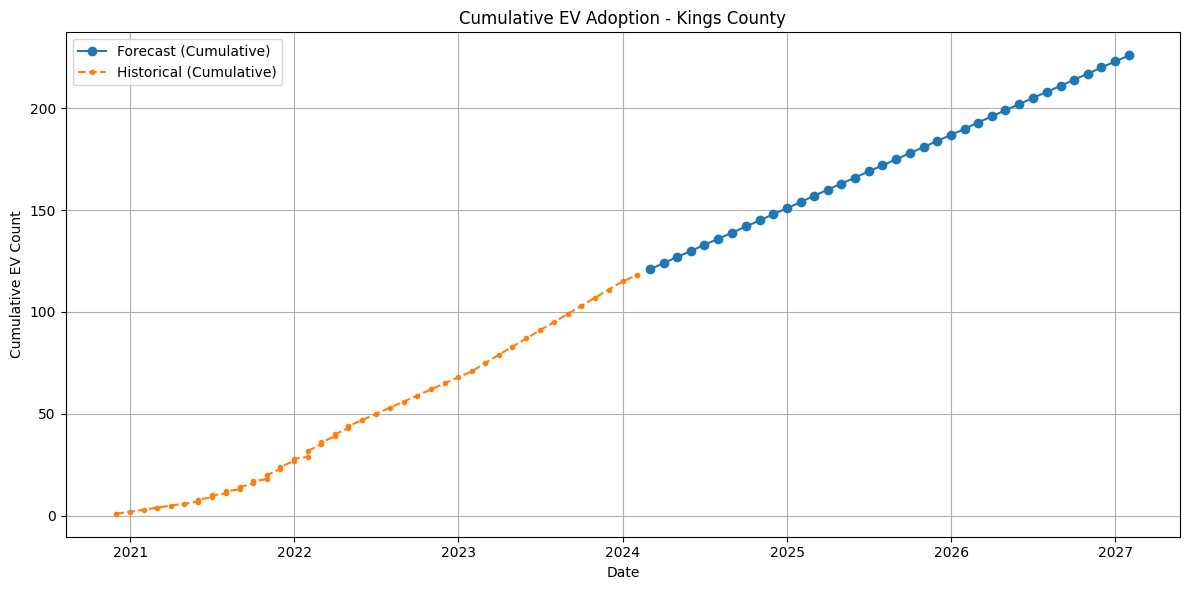

In [54]:
# --- Sort by date to ensure proper cumulative behavior ---
combined = combined.sort_values("Date")

# --- Calculate cumulative EV count ---
combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

# --- Plot cumulative EV adoption ---
plt.figure(figsize=(12, 6))
for source, group in combined.groupby('Source'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=f'{source} (Cumulative)',
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"Cumulative EV Adoption - {county} County")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

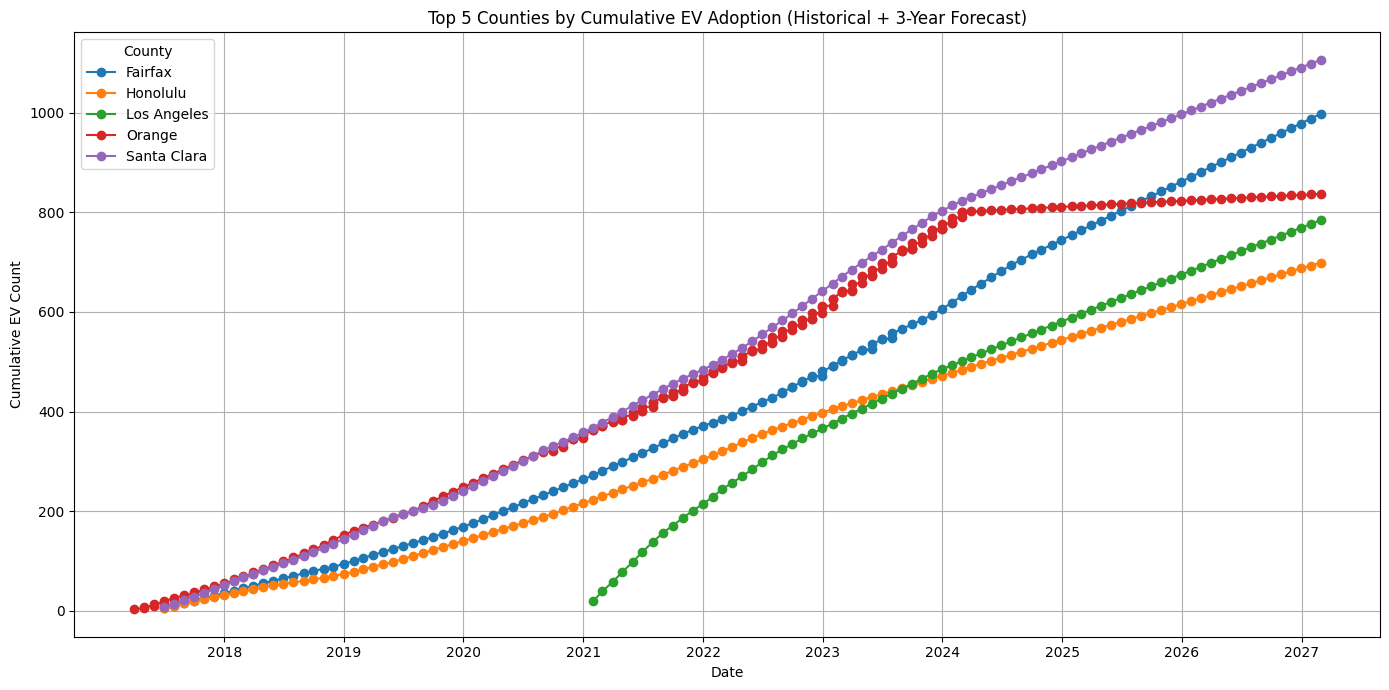

In [55]:
forecast_horizon = 36  # 3 years = 36 months

all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = le.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    # Extract initial months_since_start
    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        # Optional: track slope history for acceleration (not used here)
        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        # Store for plotting
        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        # Update EV history
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

# Combine all counties
full_df = pd.concat(all_combined)

# Get final cumulative EV count per county
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Format x-axis to show one tick per year
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()

Santa Clara leads in total EV adoption with steady growth.

Fairfax County shows consistent acceleration, projected to overtake others.

Orange County had rapid early growth but is forecast to flatten.

Honolulu County has moderate, stable growth.

Los Angeles County started later but has strong momentum, though forecast slower than the top counties

In [57]:
import joblib

# Save the trained model to file
joblib.dump(model, 'ev_charge forecasting model.pkl')
print("Model saved to 'forecasting.pkl'")

Model saved to 'forecasting.pkl'


In [58]:
loaded_model = joblib.load('ev_charge forecasting model.pkl')
print("Model loaded successfully.")



Model loaded successfully.


In [59]:
# Make predictions
# Test prediction on new or existing sample
sample = X_test.iloc[[0]]  # use one row as test
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print(f"\n🔍 Testing saved model on 1 sample:")
print(f"Actual EVs: {true_value:.2f}, Predicted EVs: {predicted_value:.2f}")


🔍 Testing saved model on 1 sample:
Actual EVs: 1.00, Predicted EVs: 1.00


 the deployment internal steamlit

In [61]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.4 MB/s eta 0:00:00


In [65]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import matplotlib.pyplot as plt

# Set Streamlit page config first thing
st.set_page_config(page_title="EV Forecast", layout="wide")

# === Load model ===
model = joblib.load('ev_charge forecasting model.pkl')

# === Styling ===
st.markdown("""
    <style>
        body {
            background-color: #fcf7f7;
            color: #000000;
        }
        .stApp {
            background: linear-gradient(to right, #c2d3f2, #7f848a);
        }
    </style>
""", unsafe_allow_html=True)

# Display image after config and styles
# Stylized title using markdown + HTML
st.markdown("""
    <div style='text-align: center; font-size: 36px; font-weight: bold; color: #FFFFFF; margin-top: 20px;'>
        🔮 EV Adoption Forecaster for a County in Washington State
    </div>
""", unsafe_allow_html=True)

# Welcome subtitle
st.markdown("""
    <div style='text-align: center; font-size: 22px; font-weight: bold; padding-top: 10px; margin-bottom: 25px; color: #FFFFFF;'>
        Welcome to the Electric Vehicle (EV) Adoption Forecast tool.
    </div>
""", unsafe_allow_html=True)

#

# Instruction line
st.markdown("""
    <div style='text-align: left; font-size: 22px; padding-top: 10px; color: #FFFFFF;'>
        Select a county and see the forecasted EV adoption trend for the next 3 years.
    </div>
""", unsafe_allow_html=True)


# === Load data (must contain historical values, features, etc.) ===
@st.cache_data
def load_data():
    df = pd.read_csv("preprocessed_ev_data.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    return df

df = load_data()

# === County dropdown ===
county_list = sorted(df['County'].dropna().unique().tolist())
county = st.selectbox("Select a County", county_list)

if county not in df['County'].unique():
    st.warning(f"County '{county}' not found in dataset.")
    st.stop()

county_df = df[df['County'] == county].sort_values("Date")
county_code = county_df['county_encoded'].iloc[0]

# === Forecasting ===
historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(historical_ev))
months_since_start = county_df['months_since_start'].max()
latest_date = county_df['Date'].max()

future_rows = []
forecast_horizon = 36

for i in range(1, forecast_horizon + 1):
    forecast_date = latest_date + pd.DateOffset(months=i)
    months_since_start += 1
    lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
    roll_mean = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0
    recent_cumulative = cumulative_ev[-6:]
    ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

    new_row = {
        'months_since_start': months_since_start,
        'county_encoded': county_code,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': roll_mean,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': ev_growth_slope
    }

    pred = model.predict(pd.DataFrame([new_row]))[0]
    future_rows.append({"Date": forecast_date, "Predicted EV Total": round(pred)})

    historical_ev.append(pred)
    if len(historical_ev) > 6:
        historical_ev.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + pred)
    if len(cumulative_ev) > 6:
        cumulative_ev.pop(0)

# === Combine Historical + Forecast for Cumulative Plot ===
historical_cum = county_df[['Date', 'Electric Vehicle (EV) Total']].copy()
historical_cum['Source'] = 'Historical'
historical_cum['Cumulative EV'] = historical_cum['Electric Vehicle (EV) Total'].cumsum()

forecast_df = pd.DataFrame(future_rows)
forecast_df['Source'] = 'Forecast'
forecast_df['Cumulative EV'] = forecast_df['Predicted EV Total'].cumsum() + historical_cum['Cumulative EV'].iloc[-1]

combined = pd.concat([
    historical_cum[['Date', 'Cumulative EV', 'Source']],
    forecast_df[['Date', 'Cumulative EV', 'Source']]
], ignore_index=True)

# === Plot Cumulative Graph ===
st.subheader(f"📊 Cumulative EV Forecast for {county} County")
fig, ax = plt.subplots(figsize=(12, 6))
for label, data in combined.groupby('Source'):
    ax.plot(data['Date'], data['Cumulative EV'], label=label, marker='o')
ax.set_title(f"Cumulative EV Trend - {county} (3 Years Forecast)", fontsize=14, color='white')
ax.set_xlabel("Date", color='white')
ax.set_ylabel("Cumulative EV Count", color='white')
ax.grid(True, alpha=0.3)
ax.set_facecolor("#1c1c1c")
fig.patch.set_facecolor('#1c1c1c')
ax.tick_params(colors='white')
ax.legend()
st.pyplot(fig)

# === Compare historical and forecasted cumulative EVs ===
historical_total = historical_cum['Cumulative EV'].iloc[-1]
forecasted_total = forecast_df['Cumulative EV'].iloc[-1]

if historical_total > 0:
    forecast_growth_pct = ((forecasted_total - historical_total) / historical_total) * 100
    trend = "increase 📈" if forecast_growth_pct > 0 else "decrease 📉"
    st.success(f"Based on the graph, EV adoption in **{county}** is expected to show a **{trend} of {forecast_growth_pct:.2f}%** over the next 3 years.")
else:
    st.warning("Historical EV total is zero, so percentage forecast change can't be computed.")


# === New: Compare up to 3 counties ===
st.markdown("---")
st.header("Compare EV Adoption Trends for up to 3 Counties")

multi_counties = st.multiselect("Select up to 3 counties to compare", county_list, max_selections=3)

if multi_counties:
    comparison_data = []

    for cty in multi_counties:
        cty_df = df[df['County'] == cty].sort_values("Date")
        cty_code = cty_df['county_encoded'].iloc[0]

        hist_ev = list(cty_df['Electric Vehicle (EV) Total'].values[-6:])
        cum_ev = list(np.cumsum(hist_ev))
        months_since = cty_df['months_since_start'].max()
        last_date = cty_df['Date'].max()

        future_rows_cty = []
        for i in range(1, forecast_horizon + 1):
            forecast_date = last_date + pd.DateOffset(months=i)
            months_since += 1
            lag1, lag2, lag3 = hist_ev[-1], hist_ev[-2], hist_ev[-3]
            roll_mean = np.mean([lag1, lag2, lag3])
            pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
            pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0
            recent_cum = cum_ev[-6:]
            ev_slope = np.polyfit(range(len(recent_cum)), recent_cum, 1)[0] if len(recent_cum) == 6 else 0

            new_row = {
                'months_since_start': months_since,
                'county_encoded': cty_code,
                'ev_total_lag1': lag1,
                'ev_total_lag2': lag2,
                'ev_total_lag3': lag3,
                'ev_total_roll_mean_3': roll_mean,
                'ev_total_pct_change_1': pct_change_1,
                'ev_total_pct_change_3': pct_change_3,
                'ev_growth_slope': ev_slope
            }
            pred = model.predict(pd.DataFrame([new_row]))[0]
            future_rows_cty.append({"Date": forecast_date, "Predicted EV Total": round(pred)})

            hist_ev.append(pred)
            if len(hist_ev) > 6:
                hist_ev.pop(0)

            cum_ev.append(cum_ev[-1] + pred)
            if len(cum_ev) > 6:
                cum_ev.pop(0)

        hist_cum = cty_df[['Date', 'Electric Vehicle (EV) Total']].copy()
        hist_cum['Cumulative EV'] = hist_cum['Electric Vehicle (EV) Total'].cumsum()

        fc_df = pd.DataFrame(future_rows_cty)
        fc_df['Cumulative EV'] = fc_df['Predicted EV Total'].cumsum() + hist_cum['Cumulative EV'].iloc[-1]

        combined_cty = pd.concat([
            hist_cum[['Date', 'Cumulative EV']],
            fc_df[['Date', 'Cumulative EV']]
        ], ignore_index=True)

        combined_cty['County'] = cty
        comparison_data.append(combined_cty)

    # Combine all counties data for plotting
    comp_df = pd.concat(comparison_data, ignore_index=True)

    # Plot
    st.subheader("📈 Comparison of Cumulative EV Adoption Trends")
    fig, ax = plt.subplots(figsize=(14, 7))
    for cty, group in comp_df.groupby('County'):
        ax.plot(group['Date'], group['Cumulative EV'], marker='o', label=cty)
    ax.set_title("EV Adoption Trends: Historical + 3-Year Forecast", fontsize=16, color='white')
    ax.set_xlabel("Date", color='white')
    ax.set_ylabel("Cumulative EV Count", color='white')
    ax.grid(True, alpha=0.3)
    ax.set_facecolor("#1c1c1c")
    fig.patch.set_facecolor('#1c1c1c')
    ax.tick_params(colors='white')
    ax.legend(title="County")
    st.pyplot(fig)

    # Display % growth for selected counties ===
    growth_summaries = []
    for cty in multi_counties:
        cty_df = comp_df[comp_df['County'] == cty].reset_index(drop=True)
        historical_total = cty_df['Cumulative EV'].iloc[len(cty_df) - forecast_horizon - 1]
        forecasted_total = cty_df['Cumulative EV'].iloc[-1]

        if historical_total > 0:
            growth_pct = ((forecasted_total - historical_total) / historical_total) * 100
            growth_summaries.append(f"{cty}: {growth_pct:.2f}%")
        else:
            growth_summaries.append(f"{cty}: N/A (no historical data)")

    # Join all in one sentence and show with st.success
    growth_sentence = " | ".join(growth_summaries)
    st.success(f"Forecasted EV adoption growth over next 3 years — {growth_sentence}")

st.success("Forecast complete")

st.markdown("Prepared for the **AICTE Internship Cycle 2 by S4F**")

Writing app.py
